In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest, f_classif
import tkinter as tk
from tkinter import filedialog, messagebox, simpledialog
from matplotlib.backends.backend_tkagg import FigureCanvasTkAgg


In [2]:
# Global variables
dataset = None
feature_selection_k = 10  # Default value for feature selection

def load_data():
    global dataset
    file_path = filedialog.askopenfilename()
    if file_path:
        dataset = load_csv(file_path)
        if dataset is not None:
            messagebox.showinfo("Success", "Dataset loaded successfully.")
            show_frame(data_frame)  # Automatically switch to the Data and Model frame

def load_csv(file_path):
    try:
        df = pd.read_csv(file_path)
        return df
    except FileNotFoundError:
        messagebox.showerror("Error", "File not found. Please check the file path.")
        return None

def preprocess_data(df):
    df['Breast'] = df['Breast'].map({'Left': 0, 'Right': 1})
    df['Breast Quadrant'] = df['Breast Quadrant'].map({'Upper inner': 0, 'Upper outer': 1, 'Lower inner': 2, 'Lower outer': 3})
    df['Diagnosis Result'] = df['Diagnosis Result'].map({'Benign': 0, 'Malignant': 1})

    df['Tumor Size (cm)'] = pd.to_numeric(df['Tumor Size (cm)'], errors='coerce')
    df['Inv-Nodes'] = pd.to_numeric(df['Inv-Nodes'], errors='coerce')

    df = df.dropna(subset=['Tumor Size (cm)', 'Inv-Nodes'])
    df = df.copy()
    df['Tumor Size Category'] = pd.cut(df['Tumor Size (cm)'], bins=[0, 2, 5, 10], labels=['Small', 'Medium', 'Large'])
    df['Inv-Nodes Category'] = pd.cut(df['Inv-Nodes'], bins=[0, 1, 5, 10], labels=['Low', 'Medium', 'High'])

    df = pd.get_dummies(df, columns=['Tumor Size Category', 'Inv-Nodes Category'])

    scaler = StandardScaler()
    numeric_features = ['Age', 'Tumor Size (cm)', 'Inv-Nodes']
    df[numeric_features] = scaler.fit_transform(df[numeric_features])

    return df

def update_feature_selection():
    global feature_selection_k
    k = simpledialog.askinteger("Feature Selection", "Enter the number of top features to select:", initialvalue=feature_selection_k, minvalue=1)
    if k is not None:
        feature_selection_k = k
        messagebox.showinfo("Feature Selection Updated", f"Feature selection updated to {feature_selection_k}.")


In [3]:
def run_model():
    global dataset, feature_selection_k
    if dataset is None:
        messagebox.showwarning("Warning", "No dataset loaded. Please load a dataset first.")
        return

    print(f"Running model with feature selection k={feature_selection_k}")

    # Preprocess the data
    df = preprocess_data(dataset)

    # Prepare the data for model training
    X = df.drop('Diagnosis Result', axis=1)
    y = df['Diagnosis Result']

    X = X.apply(pd.to_numeric, errors='coerce')
    X = X.dropna()
    y = y.loc[X.index]

    # Remove constant features
    X = X.loc[:, (X != X.iloc[0]).any()]

    # Check if feature_selection_k is greater than the number of features
    if feature_selection_k > X.shape[1]:
        messagebox.showwarning("Warning", f"Feature selection value ({feature_selection_k}) exceeds the number of available features.")
        return

    # Feature selection
    selector = SelectKBest(f_classif, k=feature_selection_k)
    X_new = selector.fit_transform(X, y)

    # Dimensionality reduction
    pca = PCA(n_components=2)
    X_pca = pca.fit_transform(X_new)

    # Train-test split
    X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size=0.2, random_state=42)

    # Train the model
    rfc = RandomForestClassifier(n_estimators=100, random_state=42)
    rfc.fit(X_train, y_train)

    # Make predictions
    y_pred = rfc.predict(X_test)

    # Evaluate the model
    matrix = confusion_matrix(y_test, y_pred)

    # Clear previous plots
    for widget in result_frame.winfo_children():
        widget.destroy()

    # Create a Canvas for scrolling
    canvas = tk.Canvas(result_frame)
    scrollbar_y = tk.Scrollbar(result_frame, orient="vertical", command=canvas.yview)
    scrollbar_x = tk.Scrollbar(result_frame, orient="horizontal", command=canvas.xview)
    canvas.configure(yscrollcommand=scrollbar_y.set, xscrollcommand=scrollbar_x.set)

    # Create a frame inside the Canvas for the plots
    plot_frame = tk.Frame(canvas)

    # Add the plot_frame to the Canvas
    canvas.create_window((0, 0), window=plot_frame, anchor='nw')

    # Configure scrollbars
    scrollbar_y.pack(side="right", fill="y")
    scrollbar_x.pack(side="bottom", fill="x")
    canvas.pack(side="left", fill="both", expand=True)

    # Update scrollregion to encompass the frame
    plot_frame.update_idletasks()
    canvas.config(scrollregion=canvas.bbox("all"))

    def update_plot_sizes(event):
        # Get canvas width and adjust figure size accordingly
        canvas_width = canvas.winfo_width()
        fig_size = (canvas_width / 100, 6)  # Adjust the height as needed

        # Clear previous plots
        for widget in plot_frame.winfo_children():
            widget.destroy()

        # Create and display all plots
        plots = []

        # Test Data Scatter Plot
        fig, ax = plt.subplots(figsize=fig_size)
        sns.scatterplot(x=X_test[:, 0], y=X_test[:, 1], hue=y_test, palette=['#1f77b4', '#d3d3d3'], s=100, alpha=0.8, ax=ax)
        ax.set_title("Test Data")
        ax.set_xlabel("Principal Component 1")
        ax.set_ylabel("Principal Component 2")
        ax.legend(title='Actual')
        plots.append(fig)

        # Add Predicted Results Scatter Plot
        fig, ax = plt.subplots(figsize=fig_size)
        sns.scatterplot(x=X_test[:, 0], y=X_test[:, 1], hue=y_pred, palette=['#1f77b4', '#d3d3d3'], s=100, alpha=0.8, ax=ax)
        ax.set_title("Predicted Results")
        ax.set_xlabel("Principal Component 1")
        ax.set_ylabel("Principal Component 2")
        ax.legend(title='Predicted')
        plots.append(fig)

        # Add Confusion Matrix
        fig, ax = plt.subplots(figsize=(canvas_width / 100, 6))
        sns.heatmap(matrix, annot=True, fmt='d', cmap='Blues', ax=ax, cbar=False)
        ax.set_xlabel('Predicted')
        ax.set_ylabel('Actual')
        ax.set_title('Confusion Matrix')
        plots.append(fig)

        # Feature Importance Plot
        importances = rfc.feature_importances_
        selected_features = X.columns[selector.get_support()]
        print(f"Selected Features: {selected_features}")  # Debug statement
        print(f"Importances: {importances}")  # Debug statement

        if len(selected_features) == len(importances):
            feature_importances = pd.DataFrame({'Feature': selected_features, 'Importance': importances}).sort_values(by='Importance', ascending=False)

            fig, ax = plt.subplots(figsize=fig_size)
            sns.barplot(x='Importance', y='Feature', data=feature_importances, ax=ax, palette='viridis')
            ax.set_title("Feature Importances")
            ax.set_xlabel("Importance")
            ax.set_ylabel("Feature")
            plots.append(fig)
        else:
            print(f"Feature count mismatch: Selected Features ({len(selected_features)}) vs Importances ({len(importances)})")

        # Display all plots in the plot_frame
        for plot in plots:
            canvas_plot = FigureCanvasTkAgg(plot, master=plot_frame)
            canvas_plot.draw()
            canvas_plot.get_tk_widget().pack(side=tk.TOP, fill=tk.BOTH, expand=True)

        # Ensure the plot_frame is resized properly
        plot_frame.update_idletasks()
        canvas.config(scrollregion=canvas.bbox("all"))

    # Bind the canvas resize event
    canvas.bind("<Configure>", update_plot_sizes)

    # Initial plot update
    update_plot_sizes(None)

    # Switch to the Results and Visualizations frame
    show_frame(result_frame)


In [4]:
def show_frame(frame):
    frame.tkraise()

def toggle_fullscreen(event=None):
    # Toggle fullscreen mode
    current_state = root.attributes("-fullscreen")
    root.attributes("-fullscreen", not current_state)

def end_fullscreen(event=None):
    # Exit fullscreen mode
    root.attributes("-fullscreen", False)


Running model with feature selection k=8
Selected Features: Index(['Age', 'Menopause', 'Tumor Size (cm)', 'Inv-Nodes', 'Metastasis',
       'Tumor Size Category_Small', 'Tumor Size Category_Large',
       'Inv-Nodes Category_Low'],
      dtype='object')
Importances: [0.78282359 0.21717641]
Feature count mismatch: Selected Features (8) vs Importances (2)
Running model with feature selection k=12
Selected Features: Index(['Age', 'Menopause', 'Tumor Size (cm)', 'Inv-Nodes', 'Breast',
       'Metastasis', 'Breast Quadrant', 'History', 'Tumor Size Category_Small',
       'Tumor Size Category_Medium', 'Tumor Size Category_Large',
       'Inv-Nodes Category_Low'],
      dtype='object')
Importances: [0.76092292 0.23907708]
Feature count mismatch: Selected Features (12) vs Importances (2)
Selected Features: Index(['Age', 'Menopause', 'Tumor Size (cm)', 'Inv-Nodes', 'Breast',
       'Metastasis', 'Breast Quadrant', 'History', 'Tumor Size Category_Small',
       'Tumor Size Category_Medium', 'Tum

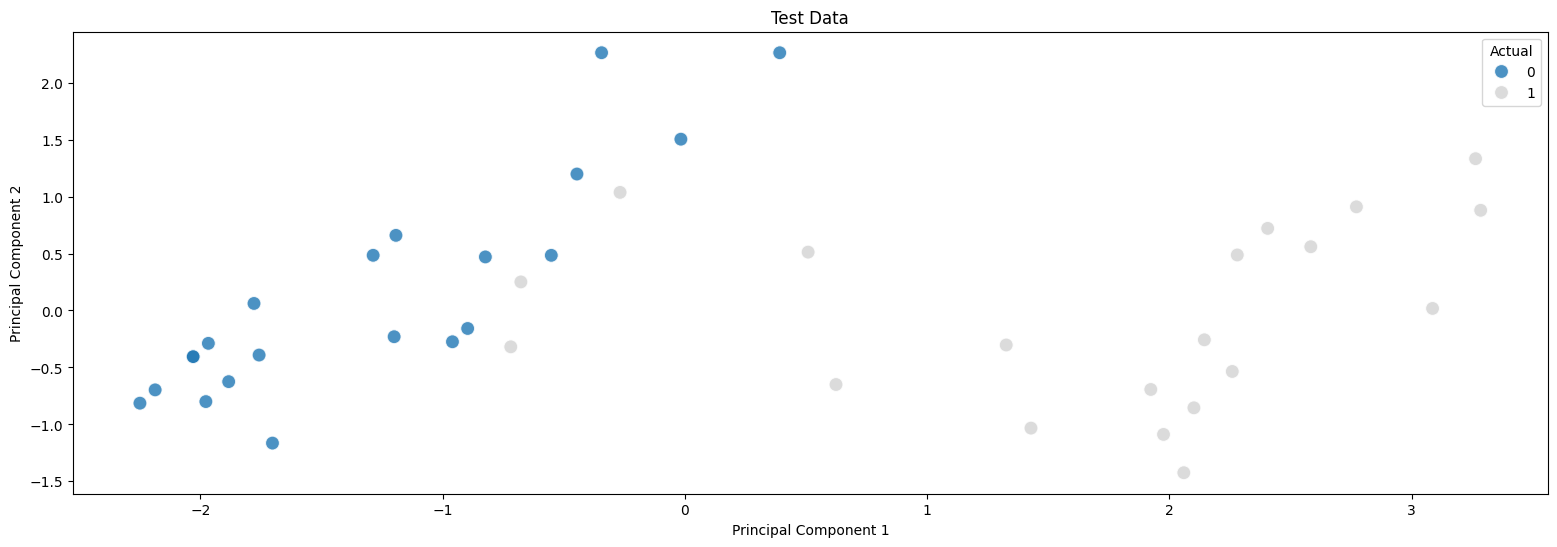

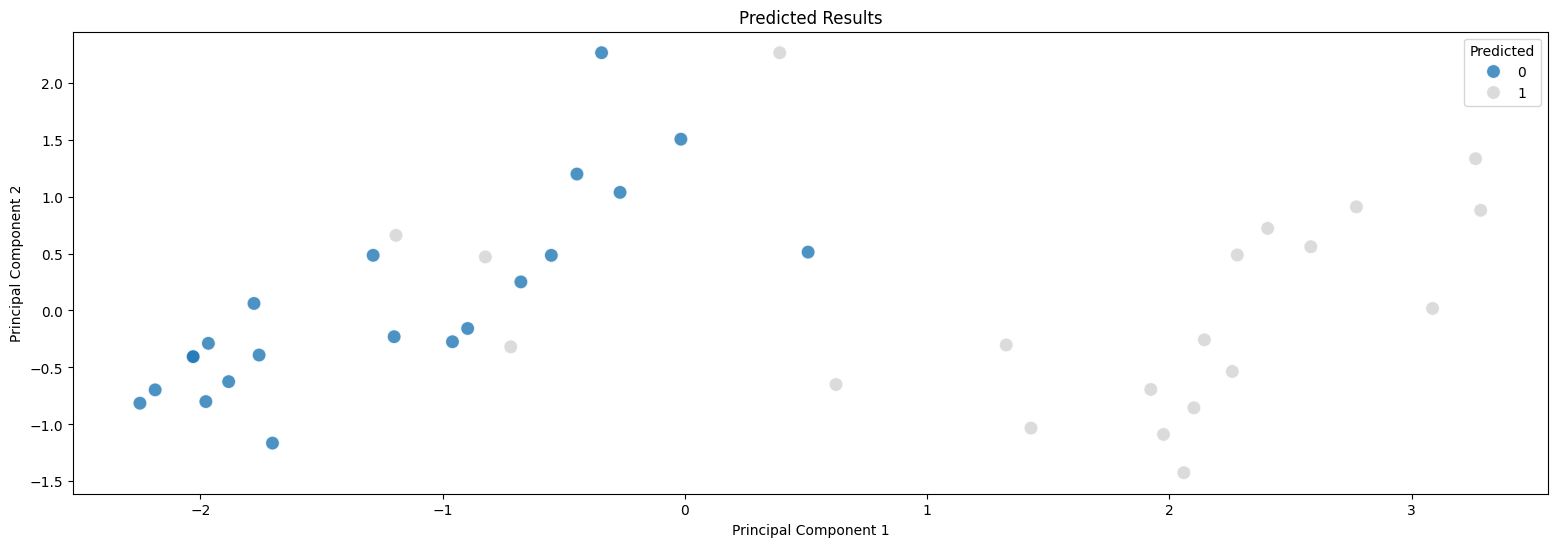

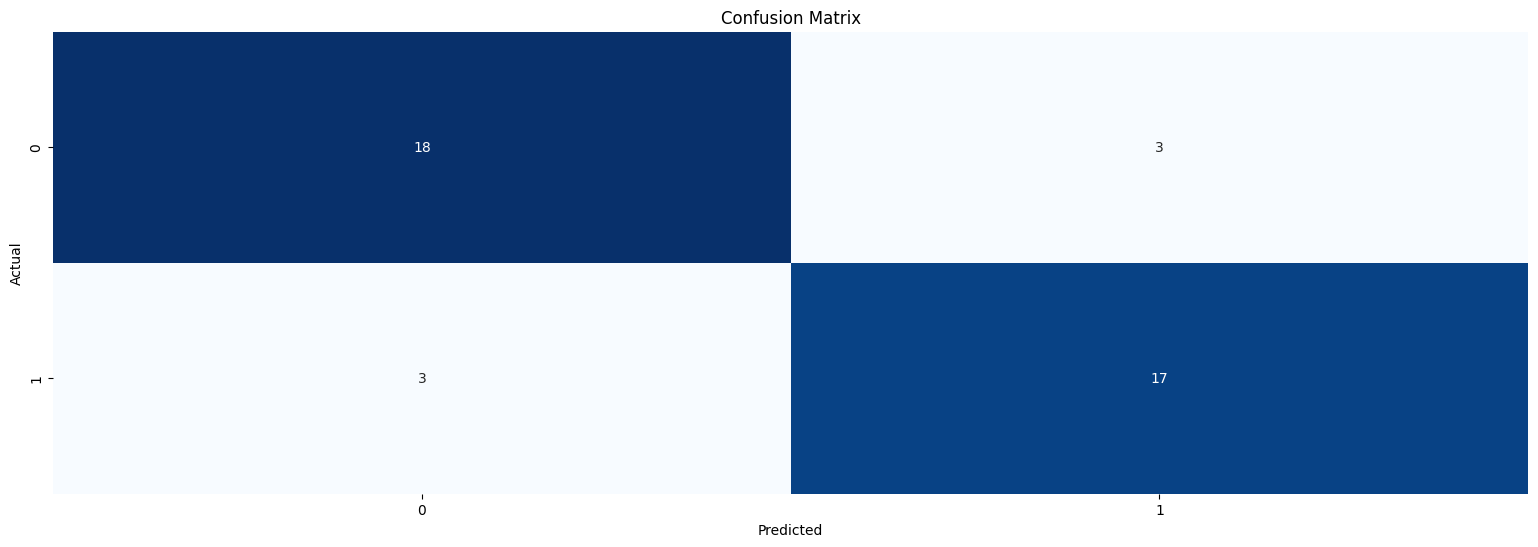

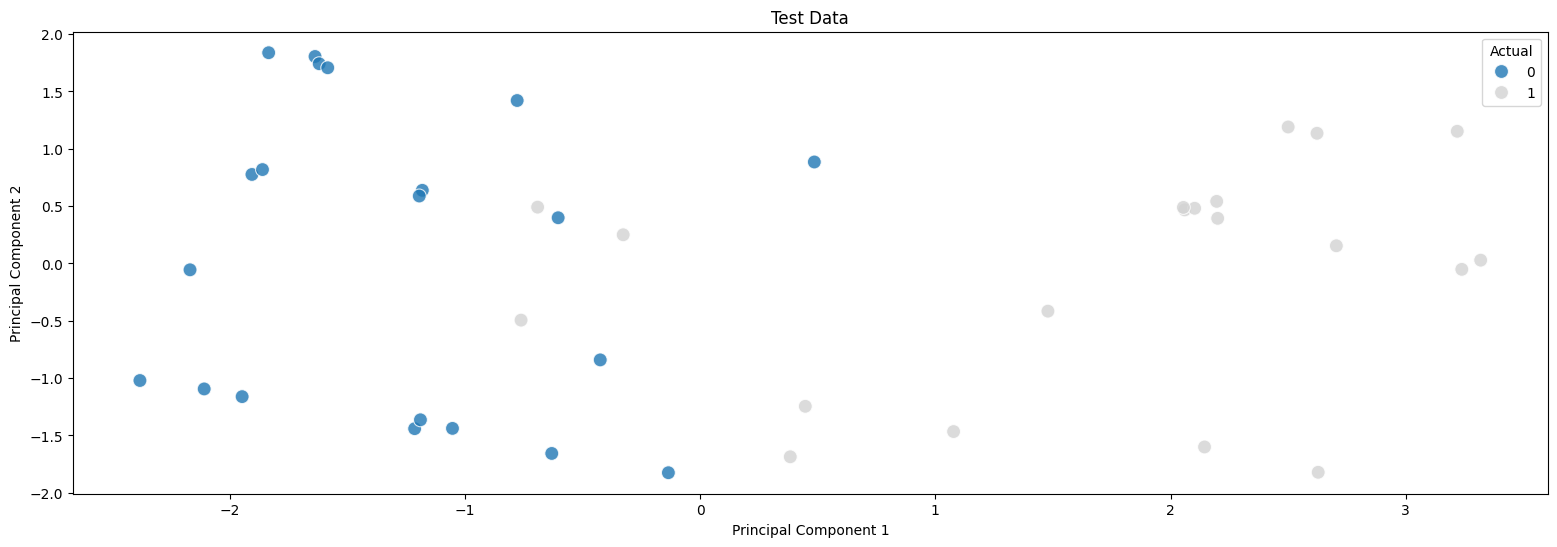

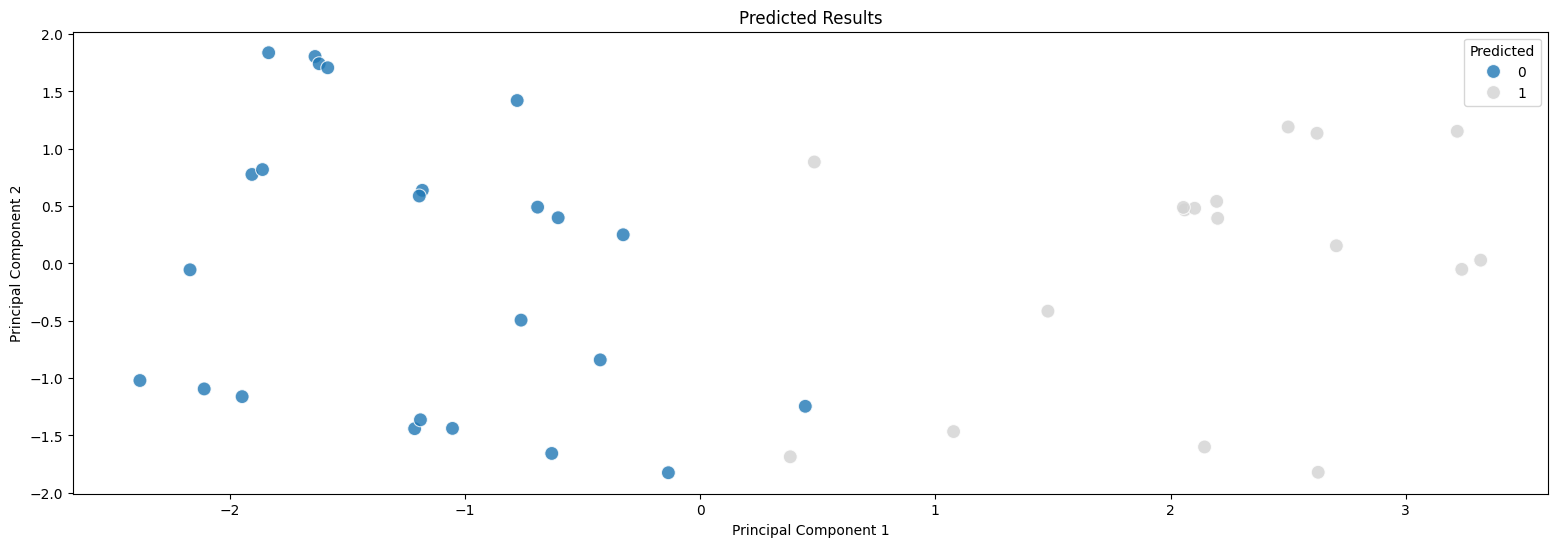

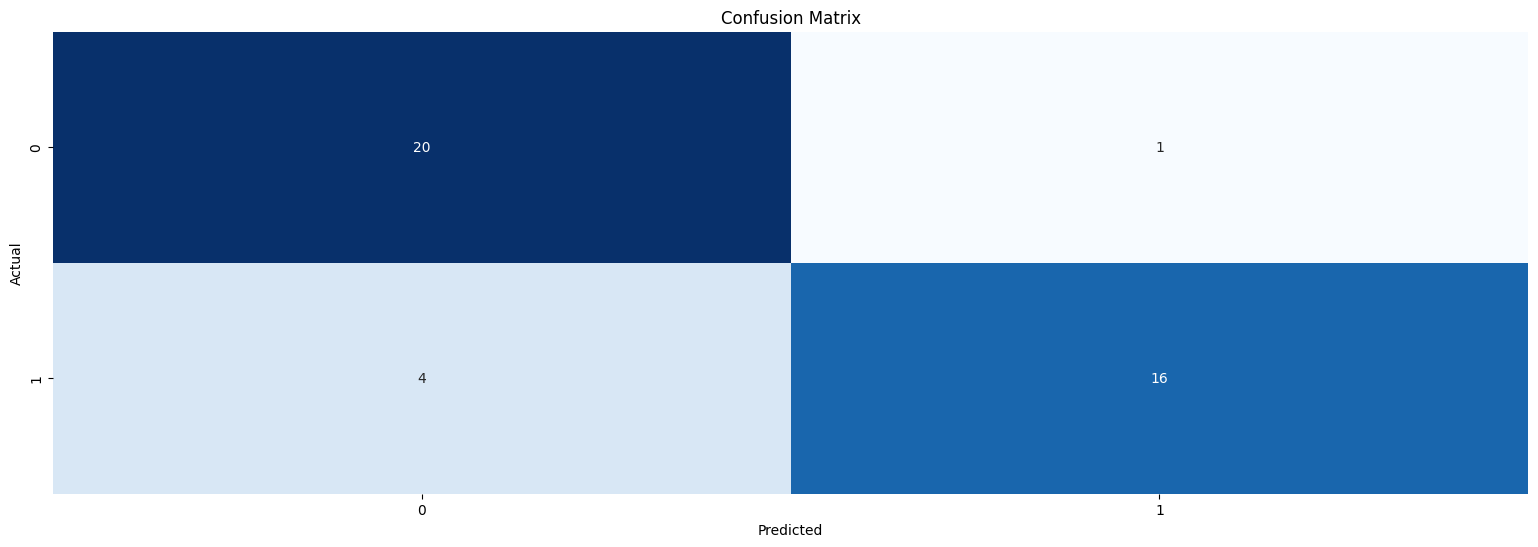

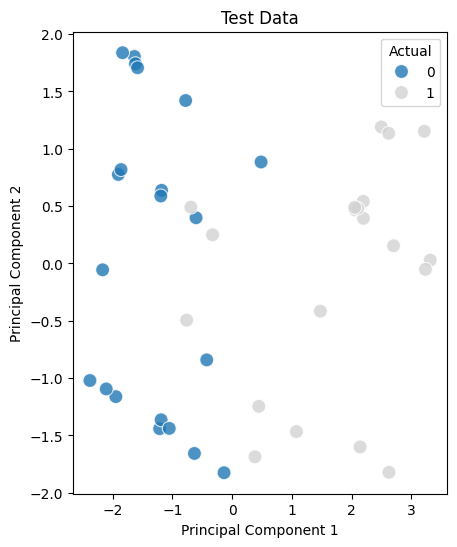

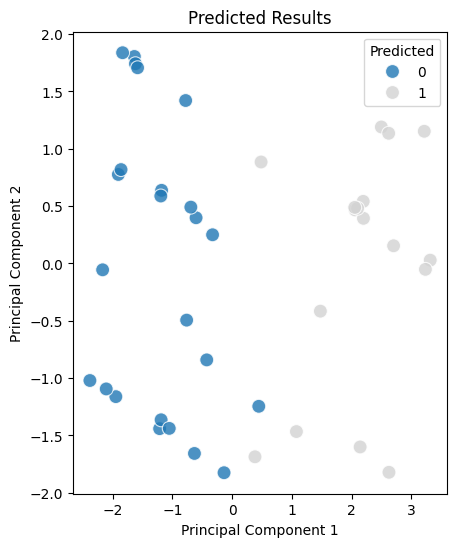

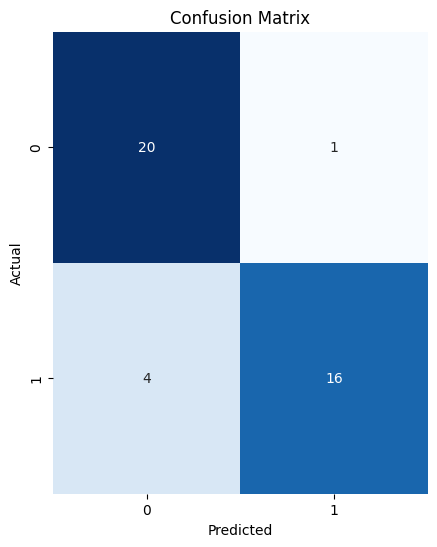

In [5]:
# Create main application window
root = tk.Tk()
root.title("Breast Cancer Diagnosis Prediction")

# Start in fullscreen mode
root.attributes("-fullscreen", True)

# Bind key events for fullscreen toggling
root.bind("<F11>", toggle_fullscreen)
root.bind("<Escape>", end_fullscreen)

# Create frames for different sections
data_frame = tk.Frame(root, bg='white')
data_frame.grid(row=0, column=0, sticky='nsew')
result_frame = tk.Frame(root, bg='white')
result_frame.grid(row=0, column=0, sticky='nsew')

# Configure row and column weights for responsive resizing
root.grid_rowconfigure(0, weight=1)
root.grid_columnconfigure(0, weight=1)
data_frame.grid_rowconfigure(0, weight=1)
data_frame.grid_columnconfigure(0, weight=1)
result_frame.grid_rowconfigure(0, weight=1)
result_frame.grid_columnconfigure(0, weight=1)

# Add a frame to hold buttons and center them
button_frame = tk.Frame(data_frame, bg='white')
button_frame.place(relx=0.5, rely=0.5, anchor='center')  # Center the button_frame

# Enhanced Navigation buttons
data_button = tk.Button(button_frame, text="Load Dataset", command=load_data, bg='#007bff', fg='white', font=('Arial', 18, 'bold'), relief='flat', padx=20, pady=10)
data_button.pack(padx=10, pady=10, fill='x')

feature_button = tk.Button(button_frame, text="Dynamic Feature Selection", command=update_feature_selection, bg='#007bff', fg='white', font=('Arial', 18, 'bold'), relief='flat', padx=20, pady=10)
feature_button.pack(padx=10, pady=10, fill='x')

run_button = tk.Button(button_frame, text="Run Model", command=run_model, bg='#007bff', fg='white', font=('Arial', 18, 'bold'), relief='flat', padx=20, pady=10)
run_button.pack(padx=10, pady=10, fill='x')

# Add the top_frame for navigation buttons in the main window
top_frame = tk.Frame(root, bg='white')
top_frame.grid(row=1, column=0, sticky='ew')
top_frame.grid_rowconfigure(0, weight=1)
top_frame.grid_columnconfigure((0, 1), weight=1)

data_button_top = tk.Button(top_frame, text="Data and Model", command=lambda: show_frame(data_frame), bg='#007bff', fg='white', font=('Arial', 16, 'bold'), relief='flat')
data_button_top.grid(row=0, column=0, padx=10, pady=10, sticky='ew')

result_button_top = tk.Button(top_frame, text="Results and Visualizations", command=lambda: show_frame(result_frame), bg='#007bff', fg='white', font=('Arial', 16, 'bold'), relief='flat')
result_button_top.grid(row=0, column=1, padx=10, pady=10, sticky='ew')

# Start with the Data and Model frame
show_frame(data_frame)

root.mainloop()
